Bayesian Online Change Point Detection 
=

Understand the model by implementation reference

## 1 符号 

- $x_1, x_2, \cdots, x_T$: 一系列的观测值, 
- $x_{a:b}$: 对于从$a$点到$b$点之间的读数为   
- $r_t$ 从上次变点开始到时间$t$,累计未发生变点的次数  
- $l$: 上一次变点在$l$个时间点之前  
- $x^{(l)}$:自上个变点后，变点发生在$l$个时间点之前，收集到的一系列新的观察值

## 2 原理与推导

### 2.1 最基本出发点

整个算法，最基础的出发点是贝叶斯后验分布:

$$\begin{align}
P(r_t|x_{1:t}) &= \dfrac{P(r_t, x_{1:t})}{P(x_{1:t})} = \dfrac{P(r_t, x_{1:t})}{\sum_{r_{t'}}P(r_{t'}, x_{1:t})} \tag{1} \\
\end{align}$$  

其最核心在于计算分子部分的概率, 我们引入前一时刻的读数和状态，则可以将分子部分展开成如下形式  
  
    
$$\begin{align}
P(r_t, x_{1:t}) &= \sum_{r_{t-1}}P(r_t, x_t, r_{t-1}, x_{1:t-1}) \\
&= \sum_{r_{t-1}}P(r_t, x_t | r_{t-1}, x_{1:t-1})P(r_{t-1}, x_{1:t-1}) \\
&= \sum_{r_{t-1}} P(x_t|r_t, r_{t-1}, x^{(l)})P(r_t|r_{t-1}, x_{1:t-1})P(r_{t-1}, x_{1:t-1}) \tag{注释1}\\
&= \sum_{r_{t-1}} P(x_t|r_t, x^{(l)})P(r_t|r_{t-1})P(r_{t-1}, x_{1:t-1}) \tag{注释2}\\
& = \sum_{r_{t-1}} \quad \underbrace{P(x_t|r_t, x^{(l)})}_{\text{UPM predictive}} \quad \underbrace{P(r_t|r_{t-1})}_{\text{Changepoint prior}} \quad \underbrace{P(r_{t-1}, x_{1:t-1})}_{\text{Message}} \tag{2}\\
\end{align}$$  
  
  


### 2.2 UPM Predictive

$P(x_t|r_t, x^{(l)})$该目标在于评估新采的样本，在已有的模型中出现的概率。以正态分布为例，计算$norm.pdf(x=x_t, mean=\mu, var=\sigma^2)$。  

原论文讨论了__指数族__的__似然形式__ $p(x|\eta) =h(x)exp\{ \eta^\intercal \ U(x) - A(\eta)\} $可以在有限的sufficient statistics上作出推论，而共轭，则可以使得$\eta$的先验和后验采用同一种指数族的概率分布. $p(\eta|\chi, \upsilon) = \bar{h}(\eta)\exp(\eta^\intercal \chi - \upsilon A(\eta) - \bar{A}(\chi, \upsilon)$, __注意：这里$\upsilon, \chi$还有待与近一步理解__

对的一般形式，论证了，共轭指数可以通过对参数加减的方式获得调整后的参数值。

$$\begin{align}
&\upsilon'=\upsilon_{prior} + N \\
&\chi'= \chi_{prior} + \sum_{n=1}^N\mu(x_n)
\end{align}$$

在实现体中，Gregory 通过对正态分布的推导，具体化了基于正态分布的贝叶斯推论是如何更新参数. 当$\sigma_x^2$不变，$\mu_0, \sigma_0^2$为先验的时候，后验在收集到$n$个数据后$\mu_n, \sigma_n^2$需变更为：
$$\begin{align}
\dfrac{1}{\sigma_n^2} & = \dfrac{1}{\sigma_0^2} + \dfrac{n}{\sigma_x^2} \\
\mu_n & =(\dfrac{n\bar{x}}{\sigma_x^2} + \dfrac{\mu_0}{\sigma_0^2}) \sigma_n^2 \\
p(x|x_{1:n}) &=\mathcal{N}(x|\mu_n, \sigma_n^2 + \sigma^2)
\end{align}$$

### 2.2.1 代码解释

#### 2.2.1.a Posterior Predictive Parameters 

在数据点$t$我们保留所有$(t+1)$个posterior predictive parameters, $ \{(\mu_0, \sigma_0^2), (\mu_1, \sigma_1^2),(\mu_2, \sigma_2^2),\cdots, (\mu_t, \sigma_t^2) \}$. 我们维护这些数据，是为了最后使用他们做出$P(x_t|r_t, x^{(l)})$


其下标标明 run length 的值，例如 $\mu_2$ 是 $l=2$ 时的 posterior predictive mean,将会有2个观察值与之相关 , $x^{(2)}= \{x_{t-1}, x_t\}$

对于各个时间点的$\sigma^2$的计算, $\sigma_x$ 认为已知

$\begin{align}
& t=0, \quad \Big[1/\sigma_0^2\Big] \\
& t=1, \quad \Big[1/\sigma_0^2, \quad \overbrace{1/\sigma_0^2 + 1/\sigma_x^2}^{\dfrac{1}{\sigma_1^2}}\Big] \\
& t=2, \quad \Big[1/\sigma_0^2, \quad 1/\sigma_0^2 + 1/\sigma_x^2, \quad  \overbrace{1/\sigma_0^2 + 2/\sigma_x^2}^{\dfrac{1}{\sigma_2^2}}\Big] \\
& t=3, \quad \Big[1/\sigma_0^2, \quad 1/\sigma_0^2 + 1/\sigma_x^2, \quad  1/\sigma_0^2 + 2/\sigma_x^2,\quad   \overbrace{1/\sigma_0^2 + 3/\sigma_x^2}^{\dfrac{1}{\sigma_3^2}}\Big] \\
\end{align}$

编码方面，我们会对每一个元素， 加上$\dfrac{1}{\sigma_x^2}$, 然后在队列前插入$\dfrac{1}{\sigma_0^2}$.     
`self.prec_params = np.array([1/var0])`  
`new_prec_params = self.prec_params + (1/self.varx)`  
`self.prec_params = np.append([1/self.var0], new_prec_params)`

我们来看看在不通时间点上的参数$\mu_n$:

$\begin{align}
& t=0, \quad \Big[\mu_0\Big] \\
& t=1, \quad \Big[\mu_0, \quad \overbrace{\sigma_1^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_1}{\sigma_x^2} \Big)}^{\mu_1} \Big] \\
& t=2, \quad \Big[\mu_0, \quad \sigma_1^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_2}{\sigma_x^2} \Big), \quad \overbrace{\sigma_2^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_1+x_2}{\sigma_x^2} \Big)}^{\mu_2} \Big] \\
& t=3, \quad \Big[\mu_0, \quad \sigma_1^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_3}{\sigma_x^2} \Big), \quad \sigma_2^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_2+x_3}{\sigma_x^2} \Big), \quad \overbrace{\sigma_2^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_1+x_2+x_3}{\sigma_x^2} \Big)}^{\mu_3} \Big] \\
\end{align}$

以$t=2$为例，数列中第二个数的参数为$x_2$,而非$x_1$，这个不是输入错误，他表达的是:
- $t=2$时，第二个参数为$l=1$时的$\mu$的计算值，此时，$x_2$是最新观察到的数值。
- 而第三个参数则表明$l=2$时的$\mu$, 此时$\{x2, x1\}$是新近观察到的值。$l=2$意味着，在过去2个时间点上刚刚发生了变点。
整个数列记录着假设在不同时间点上发生变点后$\mu$的计算值

编程上如何有效率地更新这个列表：
$$\begin{align}
\mu_{k-1} & = \sigma_{k-1}^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_1 + \cdots + x_{k-1}}{\sigma_x^2}    \Big) \\
\mu_k &= \sigma_k^2\Big( \dfrac{\mu_0}{\sigma_0^2} + \dfrac{x_1 + \cdots + x_{k-1} + x_k}{\sigma_x^2}  \Big) \\
\end{align}$$

我们可以用$\mu_{k-1}$ 来表示$\mu_k$:

$$ \mu_k = \sigma_k^2\Big( \dfrac{\mu_{k-1}}{\sigma_{k-1}^2} + \dfrac{x_k}{\sigma_x}  \Big)$$

代码上我们如下更新：对队列中每一个元素做(4)的调整，在头部插入$\mu_0$:       
`mean_params = np.array([mean0])`   
`new_mean_params = (self.mean_params * self.prec_params[:-1] + (x / self.varx)) / new_prec_params`  
`self.mean_params = np.append([self.mean0], new_mean_params)`

#### 2.2.b Posterior predictive

真正做预测的时候，就是调用norm.pdf$(data=x_t, mean=\mu_n, var=\sigma_n^2)$来计算概率值  
<code>def log_pred_prob(self, t, x):
    post_means = self.mean_params[:t]
    post_stds = np.sqrt(self.var_params[:t])
    return norm(post_means, post_stds).logpdf(x)
</code> 

### 2.3 Change Point Prior

假设我们使用$f(\tau)$表达$r_t=\tau$的概率值, $S(\tau)$ 表示存活概率, __Hazard Function__ $H(\tau)$的定义如下：

$\begin{align}
S(\tau) &= P\{T\geq\tau\}=\sum_{\tau'=\tau}^{\infty}f(\tau') \\
H(\tau) &= \dfrac{f(\tau)}{S(\tau)}
\end{align}$

Text(0.5, 1.0, 'S(x)')

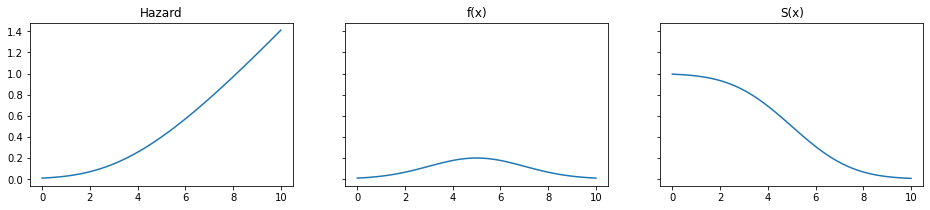

In [7]:
from scipy.stats import norm
x = np.linspace(0, 10)
f = norm(loc=5, scale=2)
a = f.pdf(x)
b = 1 - f.cdf(x)
y = a/b

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16,3))
ax1.plot(x, y);ax1.set_title("Hazard")
ax2.plot(x, a);ax2.set_title("f(x)")
ax3.plot(x, b);ax3.set_title("S(x)")

在模型中，我们的假设是change point prior如下:

$\begin{align}
P(r_t|r_{t-1}) = \begin{cases}
&H(r_{t-1} +1), & if \quad r_t=0 \\
&1-H(r_{t-1} +1), & if \quad r_t=r_{t-1} +1 \\
&0, &otherwise
\end{cases}
\end{align}$

### 2.3.1 代码解释

这里我们使用了常量，1/100

## 2.4 Messaging

Messaging 和目标保持相同的形式，是共轭形式，反复迭代就可。

### 2.4.1 代码解释
这里设定初始值为1，其后反复带入计算后的$P(r_t, x_{1:t})$

## 2.5 $P(x_{1:t})$

我们遗留了分母还没有计算，这里计算分母。这里我们形式转换$P(x_{1:t}) = \sum_{r_{t'}}P(r_{t'}, x_{1:t})$,这就转换成求$P(r_t, x_{1:t})的累加，这里我们认为$r_t$可能的取值有两个，一个是继续增长，另一个则是跌落为0,每一个可能我们都会做计算  
  
   
- Grow Probability  
$P(r_t=r_{t-1}+1| x_{1:t}) = \text{UPM predictive} \times (1-\text{Hazard()}) \times \text{Messaging})$  
  
- Change probability  
$P(r_t=0|x_{1:t}) = \text{UPM predictive} \times \text{Hazard()} \times \text{Messaging})$  
  
    
- $P(x_{1:t}) = \sum_{r_{t'}}P(r_{t'}, x_{1:t}) = \text{Grow Probability} + \text{Change Probability}$

## 2.6 Prediction

最后，我们可以依据已得到模型对新的采样点进行概率计算。

$$P(x_{t+1}|x_{1:t}) = \sum_{r_t}P(x_{t+1}|x_t^{(r)}, r_t)P(r_t|x_{1:t})$$

## 3 算法菜单

#### 1 Initialize 
$\begin{align}
&P(r_0) = S(r) \quad or \quad P(r_0=0)=1 \\
&\upsilon_1^{(0)} = \upsilon_{prior} \\
&\chi_1^{(0)} = \chi_{prior}
\end{align}$
#### 2 Observe New Datum $x_t$
#### 3 Evaluate Predictive Probability - 2.2.1.b
$\pi_t^{(r)} = P\Big(x_t|\upsilon_t^{(r)}, \chi_t^{(r)}\Big)$
#### 4 Calculate Growth Probabilities - 2.5
$P\Big(r_t=r_{t-1}+1, x_{1:t}\Big) = P\Big(r_{t-1}, x_{1:t-1}\Big)\pi_t^{(r)}\Big(1-H\big(r_{t-1}\big)\Big)$
#### 5 Calculate Changepoint Probabilities - 2.5
$P\Big( r_t=0, x_{1:t} \Big) = \sum_{r_{t-1}}P\Big(r_{t-1}, x_{1:t-1} \Big) \pi_t^{(r)} H\Big( r_{t-1} \Big)$
#### 6 Calculate Evidence - 2.5
$P\Big(x_{1:t}\Big) = \sum_{r_t}P\Big(r_t, x_{1:t}\Big)$
#### 7 Determine Run Length Distribution
$P\Big(r_t|x_{1:t}\Big) = P\Big(r_t, x_{1:t}\Big) / P\Big(x_{1:t}\Big)$
#### 8 Update Sufficient Statistics - 2.2.1.a 
$\begin{align}
\upsilon_{t+1}^{(0)} &= \upsilon_{\text{prior}} \\
\chi_{t+1}^{(0)} &= \chi_{\text{prior}} \\
\upsilon_{t+1}^{(r+l)} &= \upsilon_{t}^{(r)} + 1 \\
\chi_{t+1}^{(r+1)} &= \chi_{t}^{(r)} + \mu(x_t)\\
\end{align}$
#### 9 Perform Prediction
$P\Big(x_{t+1} | x_{1:t}\Big) = \sum_{r_t} P\Big( x_{t+1}|x_t^{(r)}, r_t\Big) P\Big( r_t|x_{1:t}\Big)$
#### 10 Return to Step 2


In [8]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import numpy as np
from   scipy.stats import norm
from   scipy.special import logsumexp

In [9]:
def bocd(data, model, hazard):
    """Return run length posterior using Algorithm 1 in Adams & MacKay 2007.
    """
    # 1. Initialize lower triangular matrix representing the posterior as
    #    function of time. Model parameters are initialized in the model class.
    #    
    #    When we exponentiate R at the end, exp(-inf) --> 0, which is nice for
    #    visualization.
    #
    log_R       = -np.inf * np.ones((T+1, T+1))
    log_R[0, 0] = 0              # log 0 == 1
    pmean       = np.empty(T)    # Model's predictive mean.
    pvar        = np.empty(T)    # Model's predictive variance. 
    log_message = np.array([0])  # log 0 == 1
    log_H       = np.log(hazard)
    log_1mH     = np.log(1 - hazard)

    for t in range(1, T+1):
        # 2. Observe new datum.
        x = data[t-1]

        # Make model predictions.
        pmean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * model.mean_params[:t])
        pvar[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * model.var_params[:t])
        
        # 3. Evaluate predictive probabilities.
        log_pis = model.log_pred_prob(t, x)

        # 4. Calculate growth probabilities.
        log_growth_probs = log_pis + log_message + log_1mH

        # 5. Calculate changepoint probabilities.
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # 6. Calculate evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)

        # 7. Determine run length distribution.
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)

        # 8. Update sufficient statistics.
        model.update_params(t, x)

        # Pass message.
        log_message = new_log_joint

    R = np.exp(log_R)
    return R, pmean, pvar

In [10]:
class GaussianUnknownMean:
    
    def __init__(self, mean0, var0, varx):
        """Initialize model.
        
        meanx is unknown; varx is known
        p(meanx) = N(mean0, var0)
        p(x) = N(meanx, varx)
        """
        self.mean0 = mean0
        self.var0  = var0
        self.varx  = varx
        self.mean_params = np.array([mean0])
        self.prec_params = np.array([1/var0])
    
    def log_pred_prob(self, t, x):
        """Compute predictive probabilities \pi, i.e. the posterior predictive
        for each run length hypothesis.
        """
        # Posterior predictive: see eq. 40 in (Murphy 2007).
        post_means = self.mean_params[:t]
        post_stds  = np.sqrt(self.var_params[:t])
        return norm(post_means, post_stds).logpdf(x)
    
    def update_params(self, t, x):
        """Upon observing a new datum x at time t, update all run length 
        hypotheses.
        """
        # See eq. 19 in (Murphy 2007).
        new_prec_params  = self.prec_params + (1/self.varx)
        self.prec_params = np.append([1/self.var0], new_prec_params)
        # See eq. 24 in (Murphy 2007).
        new_mean_params  = (self.mean_params * self.prec_params[:-1] + \
                            (x / self.varx)) / new_prec_params
        self.mean_params = np.append([self.mean0], new_mean_params)

    @property
    def var_params(self):
        """Helper function for computing the posterior variance.
        """
        return 1./self.prec_params + self.varx


In [11]:
def generate_data(varx, mean0, var0, T, cp_prob):
    """Generate partitioned data of T observations according to constant
    changepoint probability `cp_prob` with hyperpriors `mean0` and `prec0`.
    """
    data  = []
    cps   = []
    meanx = mean0
    for t in range(0, T):
        if np.random.random() < cp_prob:
            meanx = np.random.normal(mean0, var0)
            cps.append(t)
        data.append(np.random.normal(meanx, varx))
    return data, cps


In [12]:
def plot_posterior(T, data, cps, R, pmean, pvar):
    fig, axes = plt.subplots(2, 1, figsize=(20,10))

    ax1, ax2 = axes

    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)
    
    # Plot predictions.
    ax1.plot(range(0, T), pmean, c='k')
    _2std = 2 * np.sqrt(pvar)
    ax1.plot(range(0, T), pmean - _2std, c='k', ls='--')
    ax1.plot(range(0, T), pmean + _2std, c='k', ls='--')

    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
    ax2.set_xlim([0, T])
    ax2.margins(0)

    for cp in cps:
        ax1.axvline(cp, c='red', ls='dotted')
        ax2.axvline(cp, c='red', ls='dotted')

    plt.tight_layout()
    plt.show()

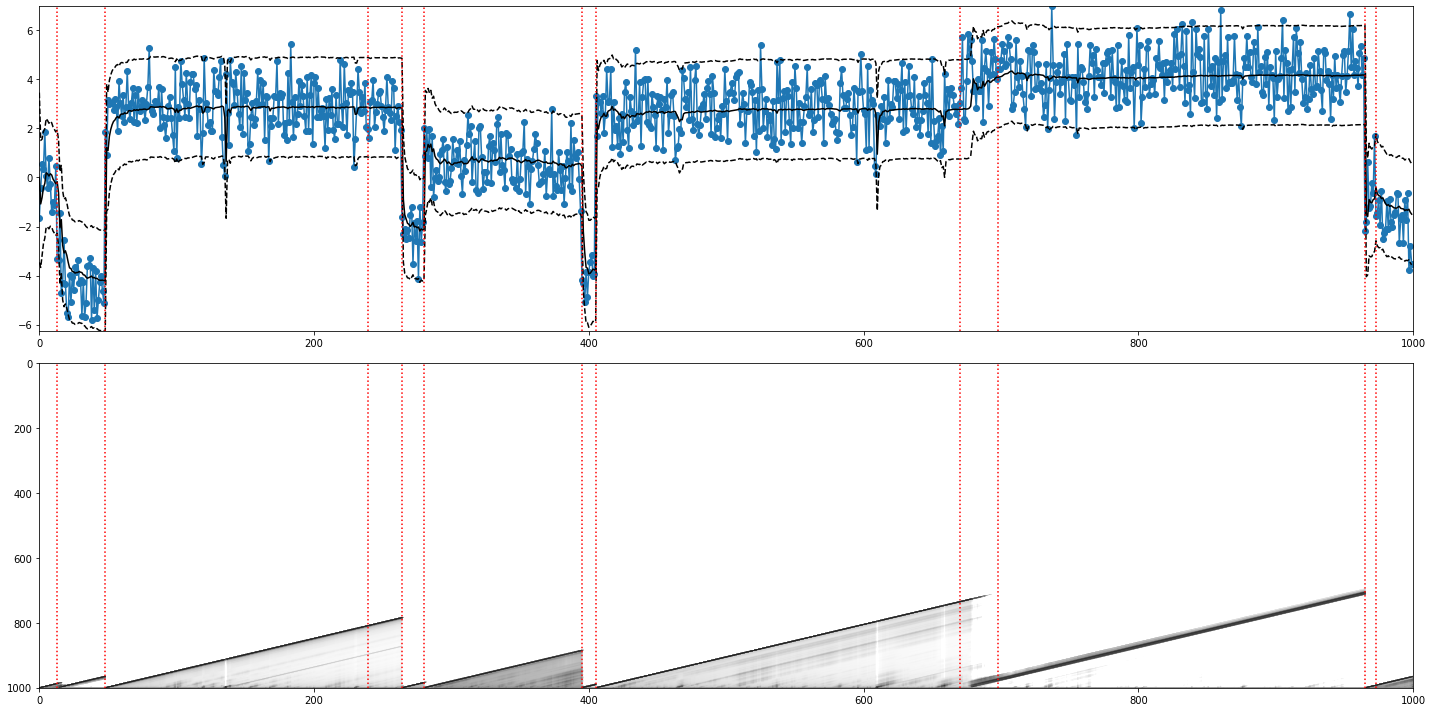

In [13]:
T      = 1000   # Number of observations.
hazard = 1/100  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps      = generate_data(varx, mean0, var0, T, hazard)
model          = GaussianUnknownMean(mean0, var0, varx)
R, pmean, pvar = bocd(data, model, hazard)

plot_posterior(T, data, cps, R, pmean, pvar)

## 参考:
- Adams, R. P., & MacKay, D. J. C. (2007). Bayesian online changepoint detection. ArXiv Preprint ArXiv:0710.3742.
- Gregory Gundersen' Blog
    - http://gregorygundersen.com/blog/2019/08/13/bocd/
    - http://gregorygundersen.com/blog/2020/10/20/implementing-bocd/
    - https://github.com/gwgundersen/bocd

### 注释
- 1 原论文使用该公式做为推导的开始，其目的在于引入$r_t$作为中间条件。此时符号$x_t^{(r)}$的定义相对模糊，我们使用公式2，给出更为明确的定义。具体为:
$$ \sum_{l=0}^tP(x_{t+1}|r_t=l, x_{(t-l):t})P(r_t=l|x_{1:t}) $$

- 2 这步推导基于我们的假设.
$$\begin{align}
p(r_t|r_{t-1}, x_{1:t-1}) & = p(r_t|r_{t-1}) \\
p(x_t | r_t, r_{t-1}, x_{1:t-1}) & = p(x_t| r_t, x^{(l)}) 
\end{align}$$  

注意：这里我们引入了使用范围的约束，即我们做出的假设条件